### Get data from Steam Community Market API and save to csv

In [72]:
import re
import requests
import pandas as pd

dailyCookie = "76561199704981720||eyAidHlwIjogIkpXVCIsICJhbGciOiAiRWREU0EiIH0.eyAiaXNzIjogInI6MTRGOV8yNDkzRTBBMF8wNzExRSIsICJzdWIiOiAiNzY1NjExOTk3MDQ5ODE3MjAiLCAiYXVkIjogWyAid2ViOmNvbW11bml0eSIgXSwgImV4cCI6IDE3MTg4MzEzNDQsICJuYmYiOiAxNzEwMTA0NDIzLCAiaWF0IjogMTcxODc0NDQyMywgImp0aSI6ICIxNEY5XzI0OTNFMEVGXzNCODY1IiwgIm9hdCI6IDE3MTgyNzM5NjQsICJydF9leHAiOiAxNzIwODM0MTkxLCAicGVyIjogMCwgImlwX3N1YmplY3QiOiAiOTAuMTk3Ljc5LjEzMyIsICJpcF9jb25maXJtZXIiOiAiOTAuMTk3Ljc5LjEzMyIgfQ.Z9jZISY3epzXX6wm51zPXf7LJ-rcs8KhrLxAyvXYSDcXnSXE2bJ1bkHzHuVOB9VJ3rs3g72lm_OkkK4g0p88AA"
items = ["Glove Case Key", "Officer Jacques Beltram | Gendarmerie Nationale", "Kilowatt Case", "AK-47 | Blue Laminate (Factory New)", "Glove Case"]

def fetch_item_to_df(item):
    # get historical price data of item from API
    url = "https://steamcommunity.com/market/pricehistory/"
    params = {
        'country': 'US',
        'currency': '1',
        'appid': '730',
        'market_hash_name': item
    }
    cookies = {'steamLoginSecure': dailyCookie}

    response = requests.get(url, params=params, cookies=cookies)
    jsonData = response.json()

    # print error message if request failed
    if response.status_code != 200:
        print(f"Failed to fetch data for {item}. Status code: {response.status_code}")
        return None

    # convert and clean data to dataframe object
    price_history = jsonData['prices']
    price_history_df = pd.DataFrame(price_history, columns=['date', 'price_usd', 'volume'])
    price_history_df['date'] = pd.to_datetime(price_history_df['date'].str[:-7], format='%b %d %Y')
    price_history_df['volume'] = pd.to_numeric(price_history_df['volume'])
    price_history_df.set_index('date', inplace=True)

    return price_history_df


def sanitize_filename(filename):
    """Sanitizes the filename to ensure it is valid for most operating systems."""
    filename = re.sub(r'[\\/*?:"<>|]', '_', filename)  # Replace disallowed characters with underscore
    filename = re.sub(r'\s+', '_', filename)  # Replace spaces with underscores
    return filename

def save_item_to_csv(item):
    csvData = './data/'+ sanitize_filename(item) +'.csv'
    fetch_item_to_df(item).to_csv(csvData, index=True)


## fetch and save data in items to csv - Uncomment this when checking new item or updating previous datasets

# for index, item in enumerate(items):
#     save_item_to_csv(item)






### Item Verification

In [73]:
# Call the method (From Notebook1) to get current_item dataframe

from matplotlib import pyplot as plt

current_item = fetch_item_to_df(items[4])

# shows what current item is, note: Array item stats with 0.
print(items[4])
print(current_item.head())



Glove Case
            price_usd  volume
date                         
2016-11-29      6.420   53686
2016-11-30      3.555   49360
2016-12-01      2.701   48668
2016-12-02      2.071   54474
2016-12-03      1.606   64918


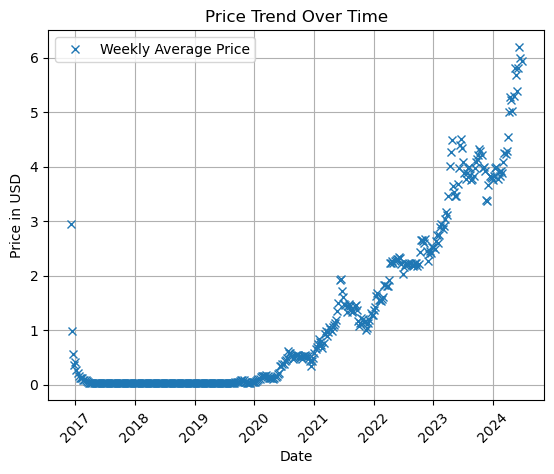

In [74]:
weekly_averages = current_item['price_usd'].resample('W').mean()

# Reset index to make 'date' a column again for plotting
weekly_averages = weekly_averages.reset_index()
plt.plot(weekly_averages['date'], weekly_averages['price_usd'], marker='x', linestyle='None', label='Weekly Average Price')

plt.xlabel('Date')
plt.ylabel('Price in USD')
plt.title('Price Trend Over Time')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.show()

### Historic Price (0)  

In [75]:
# > Historic Price (Basic)


import plotly.graph_objects as go
import pandas as pd
from ipywidgets import interact, DatePicker
import numpy as np

# renames current item to df
df = current_item

# Function to update the graph based on the selected date range
def update_graph(start_date, end_date):
    # Filtering the data based on the date range
    mask = (df.index >= pd.to_datetime(start_date)) & (df.index <= pd.to_datetime(end_date))
    filtered_data = df.loc[mask]

    # Creating the plot
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=filtered_data.index, y=filtered_data['price_usd'], mode='lines+markers', name='Price USD'))

    # Formatting
    fig.update_layout(
        title='Median Price over time (Historic Chart)',
        xaxis_title='Date',
        yaxis_title='Price USD',
        yaxis=dict(
            title='Price USD',
            titlefont_size=16,
            tickfont_size=14,
        ),
        
        showlegend=True
    )

    fig.show()


# Creating interactive widgets for date selection
start_date_picker = DatePicker(description='Start Date', value=current_item.index[0], disabled=False)
end_date_picker = DatePicker(description='End Date', value=current_item.index[-1], disabled=False)

# Display the interactive widget
interact(update_graph, start_date=start_date_picker, end_date=end_date_picker)




interactive(children=(DatePicker(value=Timestamp('2016-11-29 00:00:00'), description='Start Date'), DatePicker…

<function __main__.update_graph(start_date, end_date)>

### Volume Indicatior (1)

In [78]:
# > Volume Indicatior (1)

import plotly.graph_objects as go
import pandas as pd
from ipywidgets import interact, DatePicker
import numpy as np

# renames current item to df
df = current_item

# Function to update the graph based on the selected date range
def update_graph(start_date, end_date):
    # Filtering the data based on the date range
    mask = (df.index >= pd.to_datetime(start_date)) & (df.index <= pd.to_datetime(end_date))
    filtered_data = df.loc[mask]

    # Creating the plot
    fig = go.Figure()
    fig.add_trace(go.Bar(x=filtered_data.index, y=filtered_data['volume'], name='Price USD'))

    # Formatting
    fig.update_layout(
        title='Volume Chart',
        xaxis_title='Date',
        yaxis_title='Price USD',
        yaxis=dict(
            title='Price USD',
            titlefont_size=16,
            tickfont_size=14,
        ),
        showlegend=True
    )

    fig.show()


# Creating interactive widgets for date selection
start_date_picker = DatePicker(description='Start Date', value=current_item.index[0], disabled=False)
end_date_picker = DatePicker(description='End Date', value=current_item.index[-1], disabled=False)

# Display the interactive widget
interact(update_graph, start_date=start_date_picker, end_date=end_date_picker)



interactive(children=(DatePicker(value=Timestamp('2016-11-29 00:00:00'), description='Start Date'), DatePicker…

<function __main__.update_graph(start_date, end_date)>